<a href="https://colab.research.google.com/github/NREL/BEEAM/blob/develop/FMU/flexlab_demo/5_notebooks/validation_NMBE_CVRMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose
This notebook calculates Normalized Mean Bias Error (NMBE) and Coefficient of Variation of the Root-Mean-Square Error (CV[RMSE]) according to ASHRAE Guideline 14 for model validation, plots the results, and then saves the plots.

In [8]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Setup

In [4]:
# set to False if using private data from the research team
public = True

# dirs
if public:
  obs_dir = pre_dir = '/content/drive/My Drive/BEEAM FLEXLAB Supporting Data/3 Validation'
  out_dir = '/content/drive/My Drive'
else:
  obs_dir = '/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/FL_Data'
  pre_dir = '/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/4 Validation'
  out_dir = pre_dir
print(obs_dir, pre_dir)

# files, observed
obs_elec = 'Raw/data_FL.csv'
obs_mech = 'Final/chw_fan_15min.csv'
obs_temp = 'Final/Strat Tree Data Export_average_15min.csv'

# files, predicted, AC experiment
ac_clg = 'AC_PTAC_Clg_Coil_Cooling_Rate.csv'
ac_fan = 'AC_PTAC_Fan_electric_rate.csv'
ac_plnm_temp = 'AC_PlnmB_zone_temp.csv'
ac_zone_temp = 'AC_ZoneB_zone_temp.csv'
ac_pwr = 'AC_Vin.P.csv'

# files, predicted, DC experiment
dc_clg = 'DC_PTAC_Clg_Coil_Cooling_Rate.csv'
dc_fan = 'DC_PTAC_Fan_electric_rate.csv'
dc_plnm_temp = 'DC_PlnmB_zone_temp.csv'
dc_zone_temp = 'DC_ZoneB_zone_temp.csv'
dc_pwr = 'DC_Vin.P.csv'

# paths, observed
obs_elec_path = os.path.join(obs_dir, obs_elec)
obs_mech_path = os.path.join(obs_dir, obs_mech)
obs_temp_path = os.path.join(obs_dir, obs_temp)

# paths, predicted, AC experiment
ac_clg_path = os.path.join(pre_dir, ac_clg)
ac_fan_path = os.path.join(pre_dir, ac_fan)
ac_plnm_temp_path = os.path.join(pre_dir, ac_plnm_temp)
ac_zone_temp_path = os.path.join(pre_dir, ac_zone_temp)
ac_pwr_path = os.path.join(pre_dir, ac_pwr)

# paths, predicted, DC experiment
dc_clg_path = os.path.join(pre_dir, dc_clg)
dc_fan_path = os.path.join(pre_dir, dc_fan)
dc_plnm_temp_path = os.path.join(pre_dir, dc_plnm_temp)
dc_zone_temp_path = os.path.join(pre_dir, dc_zone_temp)
dc_pwr_path = os.path.join(pre_dir, dc_pwr)

# index column name
idx_col = 'datetime'

# column names
obs_col_name = 'Measured'
pre_col_name = 'Modeled'

# resample rule for raw data
resample_rule = '15T' 

# AC experiment beginning and end timestamps
ac_lo_beg = '2020-11-11 10:30'
ac_lo_end = '2020-11-11 17:00'
ac_md_beg = '2020-11-12 14:30'
ac_md_end = '2020-11-13 11:30'
ac_hi_beg = '2020-11-13 12:00'
ac_hi_end = '2020-11-16 08:00'
ac_beg = ac_lo_beg
ac_end = ac_hi_end

# DC experiment beginning and end timestamps
dc_hi_beg = '2020-11-17 18:00'
dc_hi_end = '2020-11-20 16:00'
dc_lo_beg = '2020-11-23 11:30'
dc_lo_end = '2020-11-25 08:45'
dc_md_beg = '2020-11-25 09:30'
dc_md_end = '2020-11-30 08:00'
dc_beg = dc_hi_beg
dc_end = dc_md_end

/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/FL_Data /content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/4 Validation


$ NMBE = \sum_{i=1}^n (y_i - \hat{y_i} ) / (n - p) * \bar{y} $

$ CV(RMSE) = \sqrt{ \sum{ (y_i - \hat{y_i})^2 } / (n - p) } / \bar{y} $

where

> $ y_i = $ single observed (measured) value
>
> $ \hat{y_i} = $ single predicted (modeled) value
>
> $ n = $ number of data points or periods
>
> $ p = $ number of parameters or terms in the
baseline model
>
> $ \bar{y} = $ arithmetic mean of the sample of n
observations


In [5]:
# function for calcs
def calcs(pre_minus_obs_series, obs_series, pre_minus_obs_squared_series):

    # NMBE sum
    nmbe_sum = pre_minus_obs_series.sum()
    print(f'NMBE sum = {nmbe_sum}')

    # number of data points
    n = obs_series.count()
    print(f'n = {n}')

    # number of parameters
    p = 1

    # mean of samples
    y_bar = obs_series.mean()
    print(f'y_bar = {y_bar}')

    # calculate NMBE
    nmbe = nmbe_sum / ((n - p) * y_bar)
    nmbe_pct = nmbe * 100
    print(f'NMBE = {nmbe}')

    # sum of sqaures for CV(RMSE)
    cvrmse_sum = pre_minus_obs_squared_series.sum()
    # print(f'CV(RMSE) sum = {cvrmse_sum}')

    # calculate CV(RMSE)
    cvrmse = (cvrmse_sum / (n - p))**0.5 / y_bar
    cvrmse_pct = cvrmse * 100
    print(f'CV(RMSE) = {cvrmse}')

    return {'nmbe':nmbe_pct, 'cvrmse':cvrmse_pct}

# Extract

In [9]:
# raw data
# obs_df = pd.read_csv(obs_path)

# observed data: electrical
obs_elec_df = pd.read_csv(obs_elec_path)
obs_raw_elec_ac_df = pd.DataFrame(obs_elec_df.loc[:, obs_elec_df.columns[0:10]])
obs_raw_elec_dc_df = pd.DataFrame(data={'time':obs_elec_df['time'], 'DC_Power_Hub':obs_elec_df['DC_Power_Hub']})

# observed data: mechanical
obs_mech_df = pd.read_csv(obs_mech_path)
# obs_raw_mech_df = pd.DataFrame(data={'time':obs_df['time'], 'HVAC_Thermal_Load':obs_df['HVAC_Thermal_Load']})

# observed data: temperatures
obs_temp_df = pd.read_csv(obs_temp_path)

# predicted data: AC
pre_ac_clg_df = pd.read_csv(ac_clg_path)
pre_ac_fan_df = pd.read_csv(ac_fan_path)
pre_ac_plnm_temp_df = pd.read_csv(ac_plnm_temp_path)
pre_ac_zone_temp_df = pd.read_csv(ac_zone_temp_path)
pre_ac_pwr_df = pd.read_csv(ac_pwr_path)

# predicted data: DC
pre_dc_clg_df = pd.read_csv(dc_clg_path)
pre_dc_fan_df = pd.read_csv(dc_fan_path)
pre_dc_plnm_temp_df = pd.read_csv(dc_plnm_temp_path)
pre_dc_zone_temp_df = pd.read_csv(dc_zone_temp_path)
pre_dc_pwr_df = pd.read_csv(dc_pwr_path)

# lists for looping
raw_df_list = [obs_raw_elec_ac_df, obs_raw_elec_dc_df] 

not_raw_df_list = [obs_mech_df, obs_temp_df,
                   pre_ac_clg_df, pre_ac_fan_df, pre_ac_plnm_temp_df, pre_ac_zone_temp_df, pre_ac_pwr_df,
                   pre_dc_clg_df, pre_dc_fan_df, pre_dc_plnm_temp_df, pre_dc_zone_temp_df, pre_dc_pwr_df]

obs_raw_elec_dc_df, obs_temp_df

(                      time  DC_Power_Hub
 0      2020-10-30 00:00:00      4.281613
 1      2020-10-30 00:01:00      4.287863
 2      2020-10-30 00:02:00      4.281352
 3      2020-10-30 00:03:00      4.270583
 4      2020-10-30 00:04:00      4.245118
 ...                    ...           ...
 46075  2020-11-30 23:55:00      6.954837
 46076  2020-11-30 23:56:00      6.970586
 46077  2020-11-30 23:57:00      6.977918
 46078  2020-11-30 23:58:00      6.961595
 46079  2020-11-30 23:59:00      6.940967
 
 [46080 rows x 2 columns],                  datetime  zone_temp  plnm_temp
 0     2020-10-30 00:00:00  25.642054  23.693248
 1     2020-10-30 00:15:00  25.685371  23.685806
 2     2020-10-30 00:30:00  25.733244  23.701334
 3     2020-10-30 00:45:00  25.775576  23.710255
 4     2020-10-30 01:00:00  25.817978  23.719775
 ...                   ...        ...        ...
 3051  2020-11-30 18:45:00  23.510949  23.481169
 3052  2020-11-30 19:00:00  23.634501  23.489393
 3053  2020-11-30 19:15:00 

# Transform

In [10]:
# loop through raw dataframes
for df in raw_df_list:
    
    # print columns
    [print(col) for col in df.columns]
    print('')

    # rename timestamp column
    df.rename(columns={'time':idx_col}, inplace=True)

    # convert timestamp
    df[idx_col] = pd.to_datetime(df[idx_col])

    # set index
    df.set_index(idx_col, inplace=True)

    # resample...doesn't work in a loop
    # df = df.resample(resample_rule).mean()

# show
obs_raw_elec_dc_df

time
AC_LED_Fixture_1
AC_LED_Fixture_2
AC_LED_Fixture_3
AC_LED_Fixture_4
AC_LED_Fixture_5
AC_LED_Fixture_6
North_desk_plug_load_emulators
East_desk_plug_load_emulators
West_desk_plug_load_emulators

time
DC_Power_Hub



,DC_Power_Hub
datetime,
2020-10-30 00:00:00,4.281613
2020-10-30 00:01:00,4.287863
2020-10-30 00:02:00,4.281352
2020-10-30 00:03:00,4.270583
2020-10-30 00:04:00,4.245118
...,...
2020-11-30 23:55:00,6.954837
2020-11-30 23:56:00,6.970586
2020-11-30 23:57:00,6.977918


In [11]:
# loop through not raw dataframe list
for df in not_raw_df_list:
    
    # print columns
    [print(col) for col in df.columns]
    print('')

    # convert timestamp
    df[idx_col] = pd.to_datetime(df[idx_col])

    # set index
    df.set_index(idx_col, inplace=True)

# show
obs_mech_df

datetime
chw
fan
chw_fan

datetime
zone_temp
plnm_temp

datetime
PTAC_Clg_Coil_Cooling_Rate

datetime
PTAC_Fan_electric_rate

datetime
PlnmB_zone_temp

datetime
ZoneB_zone_temp

datetime
Vin.P

datetime
PTAC_Clg_Coil_Cooling_Rate

datetime
PTAC_Fan_electric_rate

datetime
PlnmB_zone_temp

datetime
ZoneB_zone_temp

datetime
Vin.P



,chw,fan,chw_fan
datetime,,,
2020-10-30 00:00:00,0.955713,28.580654,29.340906
2020-10-30 00:15:00,0.889596,28.659275,29.543152
2020-10-30 00:30:00,0.875262,28.707050,29.582312
2020-10-30 00:45:00,0.880616,28.644261,29.524877
2020-10-30 01:00:00,0.896955,28.716636,29.613591
...,...,...,...
2020-11-30 06:45:00,728.836817,515.387326,1244.224143
2020-11-30 07:00:00,694.658074,514.799159,1209.457233
2020-11-30 07:15:00,630.403077,514.791260,1145.194336


## AC Experiment

### Electrical Load

In [12]:
# copy observed dataframe
ac_elec_calc_df = pd.DataFrame(obs_raw_elec_ac_df.resample(resample_rule).mean()[ac_beg:ac_end])

# sum rows
ac_elec_calc_df[obs_col_name] = ac_elec_calc_df[ac_elec_calc_df.columns[0:9]].sum(axis=1)

# add column from predicted dataframe
ac_elec_calc_df[pre_col_name] = - pre_ac_pwr_df['Vin.P']

# new dataframe for plots
ac_elec_plot_df = pd.DataFrame(ac_elec_calc_df.loc[:])

# drop columns
ac_elec_plot_df.drop(ac_elec_plot_df.columns[0:9], axis=1, inplace=True)

# set periods between experiments to NaN for calcs
ac_elec_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_elec_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
ac_elec_calc_df['pre_min_obs'] = ac_elec_calc_df[pre_col_name] - ac_elec_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_elec_calc_df['pre_min_obs_sq'] = ac_elec_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_elec_dict = calcs(ac_elec_calc_df['pre_min_obs'], ac_elec_calc_df[obs_col_name], ac_elec_calc_df['pre_min_obs_sq'])

# show
ac_elec_calc_df

NMBE sum = 2826.8250678374134
n = 381
y_bar = 1720.9357987195867
NMBE = 0.0043226559305402515
CV(RMSE) = 0.021614117370800972


,AC_LED_Fixture_1,AC_LED_Fixture_2,AC_LED_Fixture_3,AC_LED_Fixture_4,AC_LED_Fixture_5,AC_LED_Fixture_6,North_desk_plug_load_emulators,East_desk_plug_load_emulators,West_desk_plug_load_emulators,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,,,,,,,,,,
2020-11-11 10:30:00,30.698090,31.453184,31.504830,30.986242,31.046649,31.656522,150.831604,150.462491,150.545218,639.184830,900.78200,261.597170,68433.079511
2020-11-11 10:45:00,30.941650,31.794680,31.819065,31.339723,31.446393,31.935990,150.740440,150.347150,150.496330,640.861422,571.27563,-69.585792,4842.182463
2020-11-11 11:00:00,31.029683,31.917789,31.873156,31.453634,31.497008,32.039726,150.793265,150.482263,150.530903,641.617426,573.24400,-68.373426,4674.925383
2020-11-11 11:15:00,31.035374,31.924794,31.872398,31.463088,31.497793,32.049607,150.777698,150.399732,150.487324,641.507809,573.78780,-67.720009,4585.999553
2020-11-11 11:30:00,31.032450,31.929389,31.878320,31.465970,31.497076,32.054311,150.741559,150.331894,150.489880,641.420849,573.82050,-67.600349,4569.807131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16 07:00:00,58.680685,58.620884,59.176221,58.593379,59.167695,58.980424,521.219190,521.725599,521.005645,1917.169722,1944.64830,27.478578,755.072273
2020-11-16 07:15:00,58.666677,58.604074,59.161513,58.581651,59.151454,58.973112,521.342430,521.680025,521.119761,1917.280698,1944.54680,27.266102,743.440328
2020-11-16 07:30:00,58.680012,58.618090,59.170604,58.594683,59.163370,58.985236,521.251936,521.679173,520.980638,1917.123741,1944.46960,27.345859,747.796001


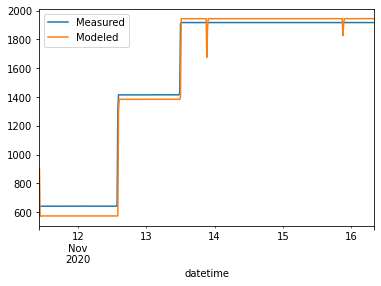

In [13]:
ac_elec_plot_df.plot()

### Cooling Load

In [14]:
# copy observed dataframe
ac_clg_calc_df = pd.DataFrame(obs_mech_df.loc[ac_beg:ac_end, 'chw']) #.resample(resample_rule).mean()[ac_beg:ac_end])

# rename column
ac_clg_calc_df.rename(columns={'chw':obs_col_name}, inplace=True)

# reverse sign of observed cooling load
# ac_mech_calc_df[obs_col_name] = ac_mech_calc_df[obs_col_name]

# add column from predicted dataframes
ac_clg_calc_df[pre_col_name] = pre_ac_clg_df['PTAC_Clg_Coil_Cooling_Rate']

# new dataframe for plots
ac_clg_plot_df = pd.DataFrame(ac_clg_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_clg_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_clg_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
ac_clg_calc_df['pre_min_obs'] = ac_clg_calc_df[pre_col_name] - ac_clg_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_clg_calc_df['pre_min_obs_sq'] = ac_clg_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_clg_dict = calcs(ac_clg_calc_df['pre_min_obs'], ac_clg_calc_df[obs_col_name], ac_clg_calc_df['pre_min_obs_sq'])

# show
ac_clg_calc_df

NMBE sum = 14654.08659802001
n = 381
y_bar = 1816.343771212546
NMBE = 0.02123132547674014
CV(RMSE) = 0.07899731878604502


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,823.578025,897.77460,74.196575,5505.131693
2020-11-11 10:45:00,807.466571,549.00085,-258.465721,66804.528749
2020-11-11 11:00:00,849.196380,540.76060,-308.435780,95132.630536
2020-11-11 11:15:00,819.859551,546.61066,-273.248891,74664.956181
2020-11-11 11:30:00,824.332418,551.76166,-272.570758,74294.818139
...,...,...,...,...
2020-11-16 07:00:00,1964.662272,2121.65330,156.991028,24646.182789
2020-11-16 07:15:00,1967.515791,2125.49220,157.976409,24956.545885
2020-11-16 07:30:00,1861.386214,2129.33400,267.947786,71796.016165


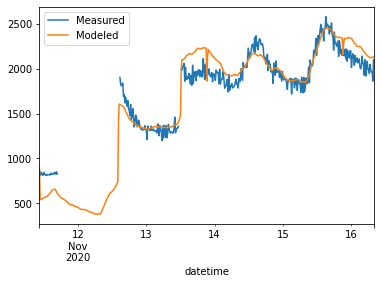

In [15]:
ac_clg_plot_df.plot()

### Temperatures

In [16]:
# copy observed dataframe
ac_zone_calc_df = pd.DataFrame(obs_temp_df.loc[ac_beg:ac_end, 'zone_temp'])

# rename column
ac_zone_calc_df.rename(columns={'zone_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
ac_zone_calc_df[pre_col_name] = pre_ac_zone_temp_df['ZoneB_zone_temp']

# copy dataframe for plots
ac_zone_plot_df = pd.DataFrame(ac_zone_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_zone_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_zone_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_zone_calc_df['pre_min_obs'] = ac_zone_calc_df[pre_col_name] - ac_zone_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_zone_calc_df['pre_min_obs_sq'] = ac_zone_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_zone_dict = calcs(ac_zone_calc_df['pre_min_obs'], ac_zone_calc_df[obs_col_name], ac_zone_calc_df['pre_min_obs_sq'])

# show
ac_zone_calc_df

NMBE sum = -141.19529782133327
n = 381
y_bar = 23.370591590082242
NMBE = -0.015898894633532355
CV(RMSE) = 0.016538506540838716


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,23.139306,22.999592,-0.139714,0.019520
2020-11-11 10:45:00,23.118969,22.999926,-0.119043,0.014171
2020-11-11 11:00:00,23.104780,23.000030,-0.104750,0.010973
2020-11-11 11:15:00,23.089950,23.000051,-0.089899,0.008082
2020-11-11 11:30:00,23.089258,23.000050,-0.089208,0.007958
...,...,...,...,...
2020-11-16 07:00:00,23.399835,22.999916,-0.399919,0.159935
2020-11-16 07:15:00,23.421530,22.999949,-0.421581,0.177731
2020-11-16 07:30:00,23.446750,22.999992,-0.446758,0.199593


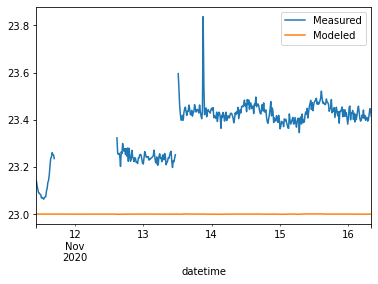

In [17]:
ac_zone_plot_df.plot()

In [18]:
# copy observed dataframe
ac_plnm_calc_df = pd.DataFrame(obs_temp_df.loc[ac_beg:ac_end, 'plnm_temp'])

# rename column
ac_plnm_calc_df.rename(columns={'plnm_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
ac_plnm_calc_df[pre_col_name] = pre_ac_plnm_temp_df['PlnmB_zone_temp']

# copy dataframe for plots
ac_plnm_plot_df = pd.DataFrame(ac_plnm_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_plnm_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_plnm_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_plnm_calc_df['pre_min_obs'] = ac_plnm_calc_df[pre_col_name] - ac_plnm_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_plnm_calc_df['pre_min_obs_sq'] = ac_plnm_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_plnm_dict = calcs(ac_plnm_calc_df['pre_min_obs'], ac_plnm_calc_df[obs_col_name], ac_plnm_calc_df['pre_min_obs_sq'])

# show
ac_plnm_calc_df

NMBE sum = -1336.6710954863331
n = 381
y_bar = 23.195086828048115
NMBE = -0.15165088798823537
CV(RMSE) = 0.15253916676797835


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,23.076363,18.356535,-4.719828,22.276773
2020-11-11 10:45:00,23.046211,18.370573,-4.675638,21.861587
2020-11-11 11:00:00,23.000329,18.359734,-4.640595,21.535126
2020-11-11 11:15:00,22.969693,18.353487,-4.616206,21.309358
2020-11-11 11:30:00,22.952131,18.361385,-4.590746,21.074945
...,...,...,...,...
2020-11-16 07:00:00,23.360472,20.249966,-3.110506,9.675249
2020-11-16 07:15:00,23.349245,20.239960,-3.109285,9.667652
2020-11-16 07:30:00,23.351945,20.234192,-3.117753,9.720385


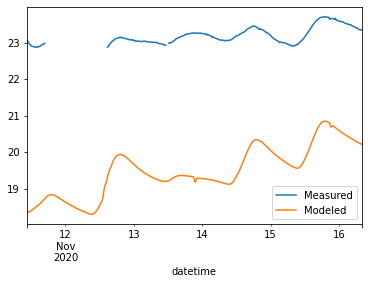

In [19]:
ac_plnm_plot_df.plot()

### Total Energy

In [20]:
# series of total energy 
ac_obs_tot_series = ac_elec_calc_df.loc[:, obs_col_name] + obs_mech_df.loc[ac_beg:ac_end, 'chw_fan']
ac_pre_tot_series = ac_elec_calc_df.loc[:, pre_col_name] + ac_clg_calc_df.loc[:, pre_col_name] + pre_ac_fan_df.loc[:, 'PTAC_Fan_electric_rate']

# dict of data
ac_total_dict = {obs_col_name:ac_obs_tot_series,
                 pre_col_name:ac_pre_tot_series}

# dataframe
ac_total_calc_df = pd.DataFrame(data=ac_total_dict)

# copy dataframe for plots
ac_total_plot_df = pd.DataFrame(ac_total_calc_df.loc[:])

# set periods between experiments to NaN for calcs
ac_total_calc_df.loc[ac_lo_end:ac_md_beg, obs_col_name] = np.nan
ac_total_calc_df.loc[ac_md_end:ac_hi_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
ac_total_calc_df['pre_min_obs'] = ac_total_calc_df[pre_col_name] - ac_total_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
ac_total_calc_df['pre_min_obs_sq'] = ac_total_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
ac_total_dict = calcs(ac_total_calc_df['pre_min_obs'], ac_total_calc_df[obs_col_name], ac_total_calc_df['pre_min_obs_sq'])

# show
ac_total_calc_df

NMBE sum = 6520.519331697469
n = 381
y_bar = 4049.1496338800594
NMBE = 0.00423774445271887
CV(RMSE) = 0.03945278885640851


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-11 10:30:00,1971.592432,2281.65923,310.066798,96141.419117
2020-11-11 10:45:00,1956.838374,1603.37911,-353.459264,124933.451598
2020-11-11 11:00:00,1999.279577,1597.10723,-402.172347,161742.597016
2020-11-11 11:15:00,1969.931797,1603.50109,-366.430707,134271.462669
2020-11-11 11:30:00,1974.061305,1608.68479,-365.376515,133499.997368
...,...,...,...,...
2020-11-16 07:00:00,4392.095733,4549.40423,157.308497,24745.963162
2020-11-16 07:15:00,4395.252294,4553.14163,157.889336,24929.042364
2020-11-16 07:30:00,4288.550847,4556.90623,268.355383,72014.611633


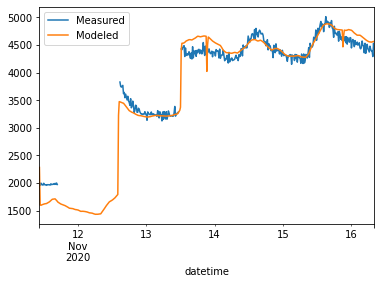

In [21]:
ac_total_plot_df.plot()

## DC Experiment

### Electrical Load

In [22]:
# copy observed dataframe
dc_elec_calc_df = pd.DataFrame(obs_raw_elec_dc_df.resample(resample_rule).mean()[dc_beg:dc_end])

# rename column
dc_elec_calc_df.rename(columns={'DC_Power_Hub':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_elec_calc_df[pre_col_name] = - pre_dc_pwr_df['Vin.P']

# new dataframe for plots
dc_elec_plot_df = pd.DataFrame(dc_elec_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_elec_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_elec_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
dc_elec_calc_df['pre_min_obs'] = dc_elec_calc_df[pre_col_name] - dc_elec_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_elec_calc_df['pre_min_obs_sq'] = dc_elec_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_elec_dict = calcs(dc_elec_calc_df['pre_min_obs'], dc_elec_calc_df[obs_col_name], dc_elec_calc_df['pre_min_obs_sq'])

# show
dc_elec_calc_df

NMBE sum = -24182.489826683748
n = 933
y_bar = 650.8149902751164
NMBE = -0.03986828497215986
CV(RMSE) = 0.043982765837487885


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,835.247643,602.23810,-233.009543,54293.447030
2020-11-17 18:15:00,835.186981,803.09296,-32.094021,1030.026162
2020-11-17 18:30:00,835.289472,803.10410,-32.185372,1035.898196
2020-11-17 18:45:00,835.067624,803.13430,-31.933324,1019.737188
2020-11-17 19:00:00,835.036771,803.09656,-31.940211,1020.177063
...,...,...,...,...
2020-11-30 07:00:00,624.850747,602.51135,-22.339397,499.048665
2020-11-30 07:15:00,624.876262,602.48740,-22.388862,501.261159
2020-11-30 07:30:00,624.795827,602.49725,-22.298577,497.226534


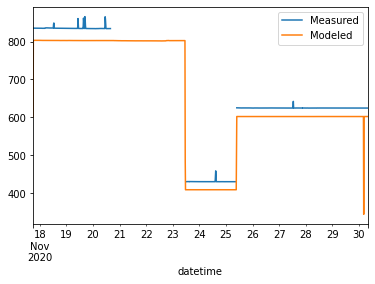

In [23]:
dc_elec_plot_df.plot()

### Cooling Load

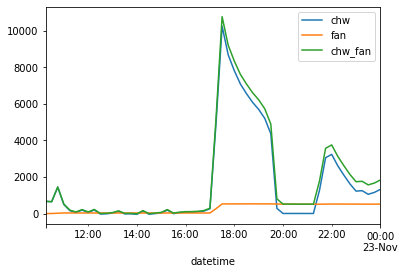

In [24]:
obs_mech_df['2020-11-22 10:15':'2020-11-23 00:00'].plot()
# '2020-11-22 10:45' 

In [25]:
# copy observed dataframe
dc_clg_calc_df = pd.DataFrame(obs_mech_df.loc[dc_beg:dc_end, 'chw'])

# rename column
dc_clg_calc_df.rename(columns={'chw':obs_col_name}, inplace=True)

# reverse sign of observed cooling load
# dc_mech_calc_df[obs_col_name] = - dc_mech_calc_df[obs_col_name]

# add column from predicted dataframes
dc_clg_calc_df[pre_col_name] = pre_dc_clg_df['PTAC_Clg_Coil_Cooling_Rate']

# set bad data to NaN
dc_clg_calc_df.loc['2020-11-22 10:15':'2020-11-23 00:00', obs_col_name] = np.nan #'2020-11-22 10:45':'2020-11-22 23:00'

# new dataframe for plots
dc_clg_plot_df = pd.DataFrame(dc_clg_calc_df)

# set periods between experiments to NaN for calcs
dc_clg_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_clg_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference of predicted and observed for NMBE
dc_clg_calc_df['pre_min_obs'] = dc_clg_calc_df[pre_col_name] - dc_clg_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_clg_calc_df['pre_min_obs_sq'] = dc_clg_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_clg_dict = calcs(dc_clg_calc_df['pre_min_obs'], dc_clg_calc_df[obs_col_name], dc_clg_calc_df['pre_min_obs_sq'])

# show
dc_clg_calc_df

NMBE sum = -93633.24243073321
n = 933
y_bar = 904.1352583501964
NMBE = -0.11111706071148236
CV(RMSE) = 0.1816817988859717


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,980.819374,901.68945,-79.129924,6261.544923
2020-11-17 18:15:00,1112.145743,1340.54980,228.404057,52168.413434
2020-11-17 18:30:00,1151.807397,1330.47530,178.667903,31922.219470
2020-11-17 18:45:00,1119.484403,1308.39120,188.906797,35685.777930
2020-11-17 19:00:00,1053.963654,1293.14540,239.181746,57207.907747
...,...,...,...,...
2020-11-30 06:45:00,728.836817,628.35850,-100.478317,10095.892178
2020-11-30 07:00:00,694.658074,626.47864,-68.179434,4648.435237
2020-11-30 07:15:00,630.403077,612.30550,-18.097577,327.522278


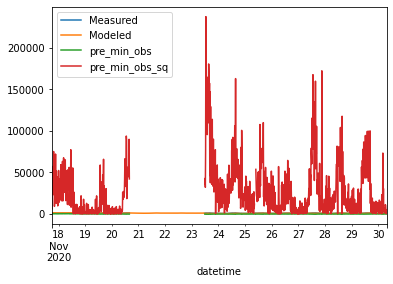

In [26]:
dc_clg_plot_df.plot()

### Temperatures

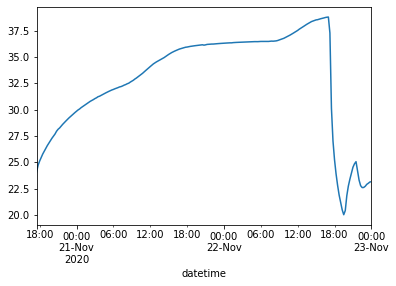

In [27]:
obs_temp_df.loc['2020-11-20 17:30':'2020-11-23 00:00', 'zone_temp'].plot()

In [28]:
# copy observed dataframe
dc_zone_calc_df = pd.DataFrame(obs_temp_df.loc[dc_beg:dc_end, 'zone_temp'])

# rename column
dc_zone_calc_df.rename(columns={'zone_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_zone_calc_df[pre_col_name] = pre_dc_zone_temp_df['ZoneB_zone_temp']

# set bad data to NaN
dc_zone_calc_df.loc['2020-11-20 17:30':'2020-11-23 00:00', obs_col_name] = np.nan

# new dataframe for plots
dc_zone_plot_df = pd.DataFrame(dc_zone_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_zone_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_zone_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
dc_zone_calc_df['pre_min_obs'] = dc_zone_calc_df[pre_col_name] - dc_zone_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_zone_calc_df['pre_min_obs_sq'] = dc_zone_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_zone_dict = calcs(dc_zone_calc_df['pre_min_obs'], dc_zone_calc_df[obs_col_name], dc_zone_calc_df['pre_min_obs_sq'])

# show
dc_zone_calc_df

NMBE sum = -145.69694198866642
n = 934
y_bar = 23.155967201272663
NMBE = -0.006743818401462836
CV(RMSE) = 0.007113529563765869


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,23.197808,22.999838,-0.197970,0.039192
2020-11-17 18:15:00,23.206877,22.998970,-0.207907,0.043225
2020-11-17 18:30:00,23.196386,22.998959,-0.197427,0.038978
2020-11-17 18:45:00,23.206489,22.999191,-0.207298,0.042973
2020-11-17 19:00:00,23.190290,22.999426,-0.190864,0.036429
...,...,...,...,...
2020-11-30 07:00:00,23.076906,22.999813,-0.077093,0.005943
2020-11-30 07:15:00,23.086813,22.999899,-0.086914,0.007554
2020-11-30 07:30:00,23.081688,22.999989,-0.081699,0.006675


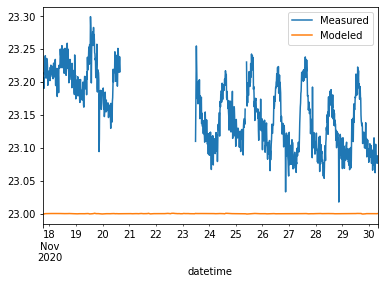

In [29]:
dc_zone_plot_df.plot()

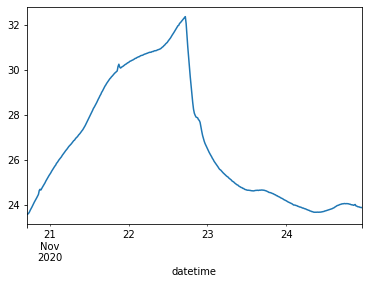

In [30]:
obs_temp_df.loc['2020-11-20 17:00':'2020-11-24 23:00', 'plnm_temp'].plot()

In [31]:
# copy observed dataframe
dc_plnm_calc_df = pd.DataFrame(obs_temp_df.loc[dc_beg:dc_end, 'plnm_temp'])

# rename column
dc_plnm_calc_df.rename(columns={'plnm_temp':obs_col_name}, inplace=True)

# add column from predicted dataframe
dc_plnm_calc_df[pre_col_name] = pre_dc_plnm_temp_df['PlnmB_zone_temp']

# set bad data to NaN
dc_plnm_calc_df.loc['2020-11-20 17:30':'2020-11-23 00:00', obs_col_name] = np.nan

# new dataframe for plots
dc_plnm_plot_df = pd.DataFrame(dc_plnm_calc_df.loc[:])

# set periods between experiments to NaN for calcs
dc_plnm_calc_df.loc[dc_hi_end:dc_lo_beg, obs_col_name] = np.nan
dc_plnm_calc_df.loc[dc_lo_end:dc_md_beg, obs_col_name] = np.nan

# calculate difference between predicted and observed for NMBE
dc_plnm_calc_df['pre_min_obs'] = dc_plnm_calc_df[pre_col_name] - dc_plnm_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_plnm_calc_df['pre_min_obs_sq'] = dc_plnm_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_plnm_dict = calcs(dc_plnm_calc_df['pre_min_obs'], dc_plnm_calc_df[obs_col_name], dc_plnm_calc_df['pre_min_obs_sq'])

# show
dc_plnm_calc_df

NMBE sum = -1149.938739437077
n = 934
y_bar = 23.568909096827703
NMBE = -0.05229420676831628
CV(RMSE) = 0.05502747809816329


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,23.863505,23.122116,-0.741389,0.549657
2020-11-17 18:15:00,23.851711,23.107925,-0.743786,0.553217
2020-11-17 18:30:00,23.870643,23.126417,-0.744226,0.553872
2020-11-17 18:45:00,23.858746,23.141815,-0.716931,0.513991
2020-11-17 19:00:00,23.856464,23.141907,-0.714557,0.510591
...,...,...,...,...
2020-11-30 07:00:00,23.126625,21.710577,-1.416048,2.005192
2020-11-30 07:15:00,23.128189,21.695200,-1.432989,2.053458
2020-11-30 07:30:00,23.110097,21.679455,-1.430642,2.046737


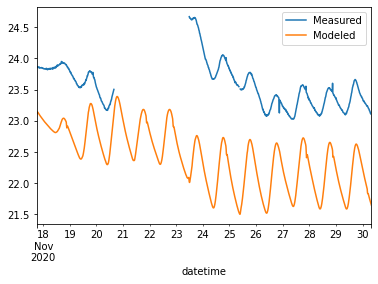

In [32]:
dc_plnm_plot_df.plot()

### Total Energy

In [33]:
# series of total energy 
dc_obs_tot_series = dc_elec_calc_df.loc[:, obs_col_name] + obs_mech_df.loc[dc_beg:dc_end, 'chw_fan']
dc_pre_tot_series = dc_elec_calc_df.loc[:, pre_col_name] + dc_clg_calc_df.loc[:, pre_col_name] + pre_dc_fan_df.loc[:, 'PTAC_Fan_electric_rate']

# dict of data
dc_total_dict = {obs_col_name:dc_obs_tot_series,
                 pre_col_name:dc_pre_tot_series}

# dataframe
dc_total_calc_df = pd.DataFrame(data=dc_total_dict)

# set bad data to NaN
dc_total_calc_df.loc['2020-11-22 10:15':'2020-11-23 00:00', obs_col_name] = np.nan #'2020-11-22 10:45':'2020-11-22 23:00'

# copy dataframe for plots
dc_total_plot_df = pd.DataFrame(dc_total_calc_df.loc[:])

# calculate difference between predicted and observed for NMBE
dc_total_calc_df['pre_min_obs'] = dc_total_calc_df[pre_col_name] - dc_total_calc_df[obs_col_name]

# calculate the square of the difference for CV(RMSE)
dc_total_calc_df['pre_min_obs_sq'] = dc_total_calc_df['pre_min_obs']**2

# calculate NMBE and CV(RMSE)
dc_total_dict = calcs(dc_total_calc_df['pre_min_obs'], dc_total_calc_df[obs_col_name], dc_total_calc_df['pre_min_obs_sq'])

# show
dc_total_calc_df

NMBE sum = -146269.27206469045
n = 932
y_bar = 2068.807378577994
NMBE = -0.07594223293507542
CV(RMSE) = 0.09818294115209648


,Measured,Modeled,pre_min_obs,pre_min_obs_sq
datetime,,,,
2020-11-17 18:00:00,2325.788246,1987.03018,-338.758066,114757.027163
2020-11-17 18:15:00,2456.737008,2626.74539,170.008382,28902.850095
2020-11-17 18:30:00,2495.995317,2616.68203,120.686713,14565.282733
2020-11-17 18:45:00,2463.337965,2594.62813,131.290165,17237.107555
2020-11-17 19:00:00,2398.378476,2579.34459,180.966114,32748.734455
...,...,...,...,...
2020-11-30 07:00:00,1834.307980,1712.09262,-122.215360,14936.594300
2020-11-30 07:15:00,1770.070599,1697.89553,-72.175069,5209.240555
2020-11-30 07:30:00,1782.205801,1682.99778,-99.208021,9842.231396


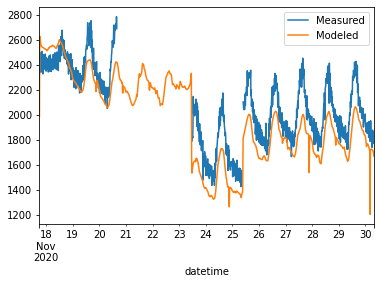

In [34]:
dc_total_plot_df.plot()

# Load

In [35]:
# use Seaborn's default theme
sns.set_theme()

# titles
elec_title = 'Electrical Load'
clg_title = 'Cooling Load'
zone_title = 'Zone Temperature'
plnm_title = 'Plenum Temperature'
total_tile = 'Total Power'

# labels
power_label = 'Power (W)'
temp_label = 'Temperature (C)'
total_label = power_label

# plot observed and predicted colors
obs_clr = 'orange'
pre_clr = 'purple'

figsize = (10, 10)
annotation_fontsize = 10

## AC Experiment

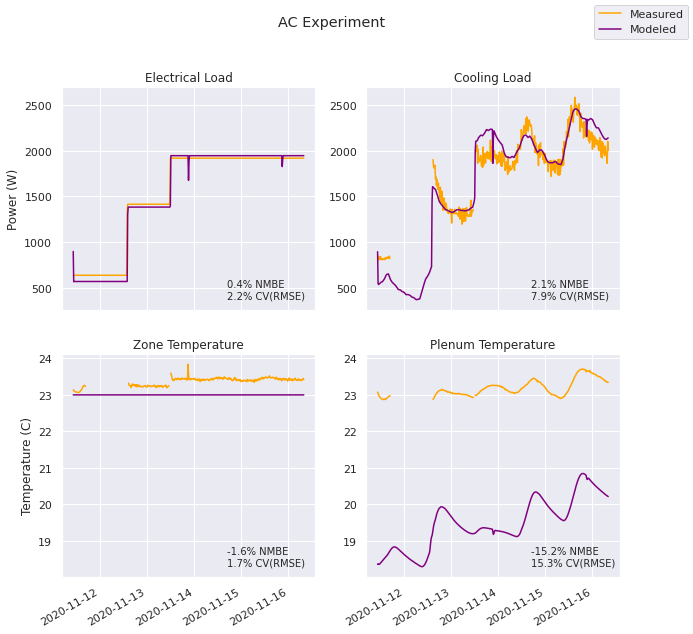

In [36]:
# figure and axes
# ac_fig, ((ac_ax1, ac_ax2), (ac_ax3, ac_ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True)

# figure
ac_fig = plt.figure(figsize=figsize)

# title
ac_fig.suptitle('AC Experiment')

# axis 1: electrical load
ac_ax1 = plt.subplot(2, 2, 1) #2grid((2,2), (0,0),)
ac_ax1.plot(ac_elec_plot_df.index, ac_elec_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax1.plot(ac_elec_plot_df.index, ac_elec_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax1.set_title(elec_title)
ac_ax1.set_ylabel(power_label)
ac_elec_nmbe = ac_elec_dict['nmbe']
ac_elec_cvrmse = ac_elec_dict['cvrmse']
ac_elec_text = f'{ac_elec_nmbe:.1f}% NMBE\n{ac_elec_cvrmse:.1f}% CV(RMSE)'
ac_ax1.annotate(s=ac_elec_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 2: cooling load
ac_ax2 = plt.subplot(2, 2, 2, sharey=ac_ax1) #2grid((2,2), (0,1),)
ac_ax2.plot(ac_clg_plot_df.index, ac_clg_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax2.plot(ac_clg_plot_df.index, ac_clg_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax2.set_title(clg_title)
ac_clg_nmbe = ac_clg_dict['nmbe']
ac_clg_cvrmse = ac_clg_dict['cvrmse']
ac_clg_text = f'{ac_clg_nmbe:.1f}% NMBE\n{ac_clg_cvrmse:.1f}% CV(RMSE)'
ac_ax2.annotate(s=ac_clg_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 3: zone temperature
ac_ax3 = plt.subplot(2, 2, 3) #2grid((2,2), (1,0),)
ac_ax3.plot(ac_zone_plot_df.index, ac_zone_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax3.plot(ac_zone_plot_df.index, ac_zone_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax3.set_title(zone_title)
ac_ax3.set_ylabel(temp_label)
ac_zone_nmbe = ac_zone_dict['nmbe']
ac_zone_cvrmse = ac_zone_dict['cvrmse']
ac_zone_text = f'{ac_zone_nmbe:.1f}% NMBE\n{ac_zone_cvrmse:.1f}% CV(RMSE)'
ac_ax3.annotate(s=ac_zone_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 4: plenum temperature
ac_ax4 = plt.subplot(2, 2, 4, sharey=ac_ax3) #2grid((2,2), (1,1),)
ac_ax4.plot(ac_plnm_plot_df.index, ac_plnm_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_ax4.plot(ac_plnm_plot_df.index, ac_plnm_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
ac_ax4.set_title(plnm_title)
ac_plnm_nmbe = ac_plnm_dict['nmbe']
ac_plnm_cvrmse = ac_plnm_dict['cvrmse']
ac_plnm_text = f'{ac_plnm_nmbe:.1f}% NMBE\n{ac_plnm_cvrmse:.1f}% CV(RMSE)'
ac_ax4.annotate(s=ac_plnm_text, xy=(0.65, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

# format x-axis
ac_fig.autofmt_xdate()

# add legend
handles, labels = ac_ax4.get_legend_handles_labels()
ac_fig.legend(handles, labels, loc='upper right')

Text(0.75, 0.05, '0.4% NMBE\n3.9% CV(RMSE)')

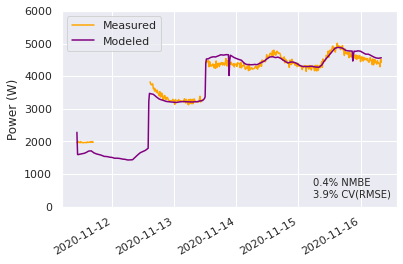

In [37]:
# create figure and axis
ac_total_fig, ac_total_ax = plt.subplots()

# set title and axis labels
ac_total_ax.set_ylabel(total_label)

# add data
ac_total_ax.plot(ac_total_plot_df.index, ac_total_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
ac_total_ax.plot(ac_total_plot_df.index, ac_total_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)

# add legend
ac_total_ax.legend(loc='upper left') #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
ac_total_ax.figure.autofmt_xdate()

# format y-axis
ac_total_ax.set_ylim(ymin=0, ymax=6000)

# annotation
ac_total_nmbe = ac_total_dict['nmbe']
ac_total_cvrmse = ac_total_dict['cvrmse']
ac_total_text = f'{ac_total_nmbe:.1f}% NMBE\n{ac_total_cvrmse:.1f}% CV(RMSE)'
ac_total_ax.annotate(s=ac_total_text, xy=(0.75, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

## DC Experiment

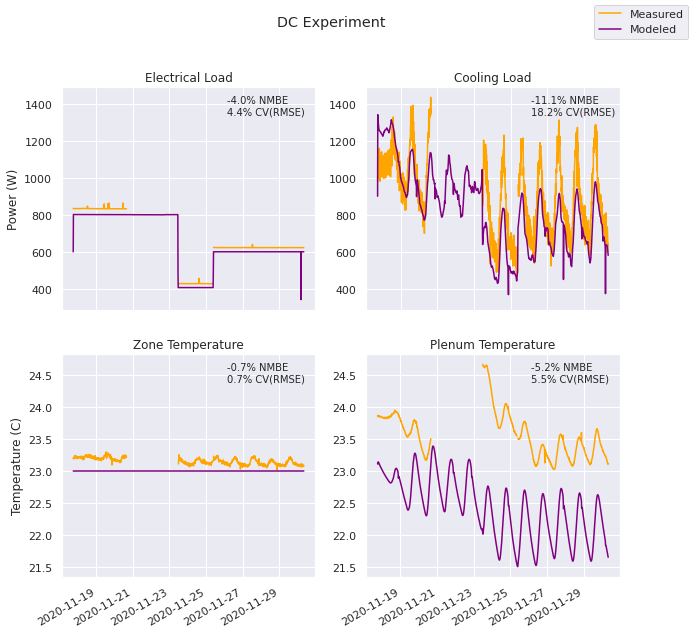

In [38]:
# figure
dc_fig = plt.figure(figsize=figsize)

annotation_x = 0.65
annotation_y = 0.875

# title
dc_fig.suptitle('DC Experiment')

# axis 1: electrical load
dc_ax1 = plt.subplot(2, 2, 1) #2grid((2,2), (0,0),)
dc_ax1.plot(dc_elec_plot_df.index, dc_elec_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax1.plot(dc_elec_plot_df.index, dc_elec_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax1.set_title(elec_title)
dc_ax1.set_ylabel(power_label)
dc_elec_nmbe = dc_elec_dict['nmbe']
dc_elec_cvrmse = dc_elec_dict['cvrmse']
dc_elec_text = f'{dc_elec_nmbe:.1f}% NMBE\n{dc_elec_cvrmse:.1f}% CV(RMSE)'
dc_ax1.annotate(s=dc_elec_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 2: cooling load
dc_ax2 = plt.subplot(2, 2, 2, sharey=dc_ax1) #2grid((2,2), (0,1),)
dc_ax2.plot(dc_clg_plot_df.index, dc_clg_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax2.plot(dc_clg_plot_df.index, dc_clg_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax2.set_title(clg_title)
dc_clg_nmbe = dc_clg_dict['nmbe']
dc_clg_cvrmse = dc_clg_dict['cvrmse']
dc_clg_text = f'{dc_clg_nmbe:.1f}% NMBE\n{dc_clg_cvrmse:.1f}% CV(RMSE)'
dc_ax2.annotate(s=dc_clg_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 3: zone temperature
dc_ax3 = plt.subplot(2, 2, 3) #2grid((2,2), (1,0),)
dc_ax3.plot(dc_zone_plot_df.index, dc_zone_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax3.plot(dc_zone_plot_df.index, dc_zone_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax3.set_title(zone_title)
dc_ax3.set_ylabel(temp_label)
dc_zone_nmbe = dc_zone_dict['nmbe']
dc_zone_cvrmse = dc_zone_dict['cvrmse']
dc_zone_text = f'{dc_zone_nmbe:.1f}% NMBE\n{dc_zone_cvrmse:.1f}% CV(RMSE)'
dc_ax3.annotate(s=dc_zone_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# axis 4: plenum temperature
dc_ax4 = plt.subplot(2, 2, 4, sharey=dc_ax3) #2grid((2,2), (1,1),)
dc_ax4.plot(dc_plnm_plot_df.index, dc_plnm_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_ax4.plot(dc_plnm_plot_df.index, dc_plnm_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)
dc_ax4.set_title(plnm_title)
dc_plnm_nmbe = dc_plnm_dict['nmbe']
dc_plnm_cvrmse = dc_plnm_dict['cvrmse']
dc_plnm_text = f'{dc_plnm_nmbe:.1f}% NMBE\n{dc_plnm_cvrmse:.1f}% CV(RMSE)'
dc_ax4.annotate(s=dc_plnm_text, xy=(annotation_x, annotation_y), xycoords='axes fraction', fontsize=annotation_fontsize)

# format x-axis
dc_fig.autofmt_xdate()

# add legend
handles, labels = dc_ax4.get_legend_handles_labels()
dc_fig.legend(handles, labels, loc='upper right')

Text(0.75, 0.05, '-7.6% NMBE\n9.8% CV(RMSE)')

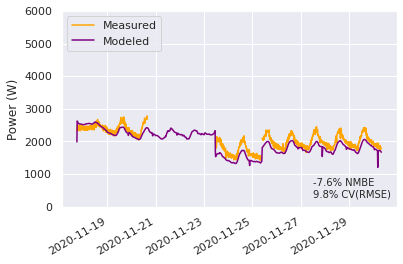

In [39]:
# create figure and axis
dc_total_fig, dc_total_ax = plt.subplots()

# set title and axis labels
dc_total_ax.set_ylabel(total_label)

# add data
dc_total_ax.plot(dc_total_plot_df.index, dc_total_plot_df[obs_col_name], label=obs_col_name, color=obs_clr)
dc_total_ax.plot(dc_total_plot_df.index, dc_total_plot_df[pre_col_name], label=pre_col_name, color=pre_clr)

# add legend
dc_total_ax.legend(loc='upper left') #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
dc_total_ax.figure.autofmt_xdate()

# format y-axis
dc_total_ax.set_ylim(ymin=0, ymax=6000)

# annotation
dc_total_nmbe = dc_total_dict['nmbe']
dc_total_cvrmse = dc_total_dict['cvrmse']
dc_total_text = f'{dc_total_nmbe:.1f}% NMBE\n{dc_total_cvrmse:.1f}% CV(RMSE)'
dc_total_ax.annotate(s=dc_total_text, xy=(0.75, 0.05), xycoords='axes fraction', fontsize=annotation_fontsize)

## Save

In [ ]:
# save
ac_fig.savefig(os.path.join(out_dir, 'validation_ac.png'), bbox_inches='tight', dpi=300)
# ac_total_fig.savefig(os.path.join(out_dir, 'ac_validation_total.png'), bbox_inches='tight', dpi=300)
dc_fig.savefig(os.path.join(out_dir, 'validation_dc.png'), bbox_inches='tight', dpi=300)
# dc_total_fig.savefig(os.path.join(out_dir, 'dc_validation_total.png'), bbox_inches='tight', dpi=300)